In [0]:
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras
import sklearn.metrics as metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
import collections
import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)
plt.rc_context({'xtick.color':'w', 'ytick.color':'w', 'text.color':'w', 'axes.labelcolor':'w'})
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

!pip install -q keras

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
drive.ListFile({'q': "'1EYL1Xky9v3LygcLztNjbxlpbc2RFmyon' in parents and trashed=false"}).GetList()
data_downloaded=drive.CreateFile({'id': '1AcUHDj2sdcehV5aTv-34GNc9Lo7_5-Tm'})
data_downloaded.GetContentFile('Metro_Interstate_Traffic_Volume.csv')

In [0]:
data=pd.read_csv('Metro_Interstate_Traffic_Volume.csv',low_memory=False, lineterminator='\n')
data.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume\r
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [0]:
df=data
df['date_time'] = pd.to_datetime(df.date_time)
df['year'] = df.date_time.dt.year
df=df.drop(['holiday','weather_main','weather_description','temp','rain_1h','snow_1h','clouds_all','date_time'],axis='columns')
df.head()

,traffic_volume\r,year
0,5545,2012
1,4516,2012
2,4767,2012
3,5026,2012
4,4918,2012


In [0]:
df_train=df[df['year']==2016]
df_train=df_train.drop(['year'],axis='columns')
df_train.shape

(9306, 1)

In [0]:
df_validation=df[df['year']==2017]
df_validation=df_validation.drop(['year'],axis='columns')
df_validation.shape

(10605, 1)

In [0]:
df_test=df[df['year']==2018]
df_test=df_test.drop(['year'],axis='columns')
df_test.shape

(7949, 1)

In [0]:
df_train=df_train.values.tolist()
df_validation=df_validation.values.tolist()
df_test=df_test.values.tolist()

In [0]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [0]:
#720 = 30 dias
x_train, y_train = split_sequence(df_train, 720)
x_val, y_val = split_sequence(df_validation, 720)

In [0]:
x_train=x_train.reshape((x_train.shape[0],x_train.shape[1]))
x_train.shape

(8586, 720)

In [0]:
y_train=y_train.reshape((y_train.shape[0],y_train.shape[1]))
y_train.shape

(8586, 1)

In [0]:
x_val=x_val.reshape((x_val.shape[0],x_val.shape[1]))
x_val.shape

(9885, 720)

In [0]:
y_val=y_val.reshape((y_val.shape[0],y_val.shape[1]))
y_train.shape

(8586, 1)

In [0]:
# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=720))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               72100     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 72,201
Trainable params: 72,201
Non-trainable params: 0
_________________________________________________________________


In [0]:
# fit model
history=model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=5000, verbose=1)

Streaming output truncated to the last 5000 lines.
269/269 [==============================] - 1s 3ms/step - loss: 10579.2334 - mae: 79.5582 - val_loss: 1421940.0000 - val_mae: 927.2587
Epoch 2502/5000
269/269 [==============================] - 1s 3ms/step - loss: 13226.9014 - mae: 90.1123 - val_loss: 1440210.3750 - val_mae: 937.9343
Epoch 2503/5000
269/269 [==============================] - 1s 3ms/step - loss: 13623.2393 - mae: 91.8960 - val_loss: 1426499.8750 - val_mae: 932.6895
Epoch 2504/5000
269/269 [==============================] - 1s 3ms/step - loss: 10985.7031 - mae: 83.0260 - val_loss: 1447654.3750 - val_mae: 941.9992
Epoch 2505/5000
269/269 [==============================] - 1s 3ms/step - loss: 10472.2910 - mae: 80.2666 - val_loss: 1462057.5000 - val_mae: 939.7698
Epoch 2506/5000
269/269 [==============================] - 1s 3ms/step - loss: 11341.5908 - mae: 83.2126 - val_loss: 1443253.0000 - val_mae: 936.1321
Epoch 2507/5000
269/269 [==============================] - 1s 3ms

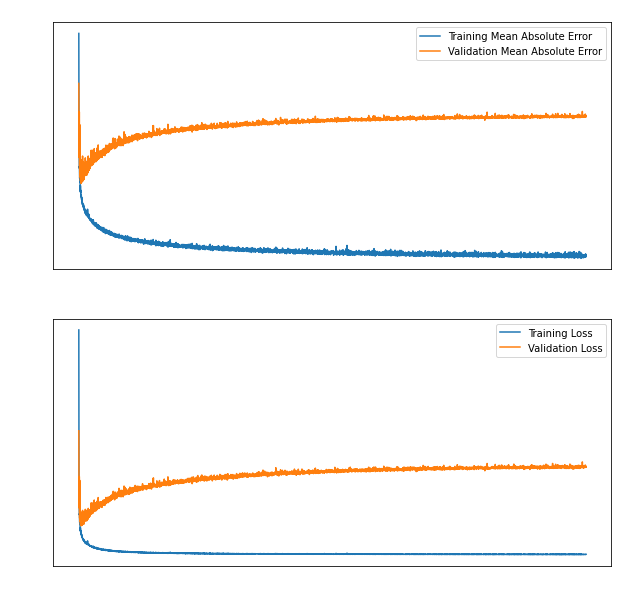

In [0]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(mae, label='Training Mean Absolute Error')
plt.plot(val_mae, label='Validation Mean Absolute Error')
plt.legend(loc='lower right')
plt.setp(plt.legend().get_texts(), color='black')
plt.ylabel('Mean Absolute Error')
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.title('Training and Validation Mean Absolute Error')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.setp(plt.legend().get_texts(), color='black')
plt.ylabel('Cross Entropy')
plt.ylim(min(plt.ylim()),max(plt.ylim()))
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
# demonstrate prediction
x_test, y_test = split_sequence(df_test, 720)
x_t=x_test[0]
x_t=x_t.reshape((1,x_t.shape[0]))
y_t=y_test[0]
y_t=y_t.reshape((1,y_t.shape[0]))

In [0]:
preds = model.predict(x_t, verbose=0)
print("Real: %d\nPrediccion: %d" % (y_t,preds))

Real: 3637
Prediccion: 4013


In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(y_t, preds))
print("RMSE: %d" % (rmse))

RMSE: 376
